<a href="https://colab.research.google.com/github/jlindsteadt/robot_clone/blob/master/macro/research/erc_risk_parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equal Risk Contribution 

Portfolio construction in the RP strategy is all about diversification.
BUT... what is diversification really, how do we measure it, how do we construct a portfolio that maximises it, and what are the trade-offs in doing so?

## First... some terminology

So that we're all on the same page, here are some important terms:  
- "risk parity": generic procedure of trying to equalise volatility
- "inverse vol weighting": sizing positions in inverse proportion to their volatility, what we've also called "naive risk parity". Ignores co-movement of assets.
- "equal risk contribution": (ERC) a risk-parity implementation that takes into account co-movement of assets. 

## Diversification depends on how you define it

In the inverse vol wighting approach, we size each asset to deliver an equal amount of volatility to the portfolio *as if we could sum the individual volatilities to get our portfolio volatility.* 

In this framework, "diversification" is measured by the equality of each (sized) asset's independent volatility. 

The portfolio that maximises it is the one whose weights result in precisely equal independent volatilities of the assets. 

However, we know that assets aren't completley independent. We saw in week 1 that some asset classes are more and less like others. 

In the extreme case, inverse volatility weighting two assets that move in lock step is the same as going all in on one of them. The second asset provides no diversification benefit to the portfolio. 

ERC measures "diversification" by considering the contribution of each asset to the volatility of the portfolio as a whole. 

Rather than considering each asset as independent from the rest, it acknowledges that some are more similar than others. Some will therefore have a greater diversifying effect than others at the portfolio level. 

It considers how much volatility each component contributes in relation to all the other components, rather than independently of the other components.

Here’s a simple example. Say we have a portfolio that consists of four assets. Two of those are highly correlated to one another, the other two are uncorrelated with the others.

The inverse vol approach will weight each asset according to its own volatility. The result is that each asset would be sized to deliver 25% of it's volatility. Since two of those assets are very similar, this is equivalent to having a portfolio of three assets with weights (0.5, 0.25, 0.25).

ERC considers the correlations between each asset with all the others. The two highly correlated assets will be weighted such that together they contribute around one third of the portfolio volatility, while the other two assets contribute the remaining two thirds. The weights would be (0.165, 0.165, 0.33, 0.33).

Everything is a trade off. ERC sounds good, but it depends on predicting future dependencies between assets. To what extent can we do that? Is there a danger that we end up relying on too much precision in what is really a sea of noise? And if we *can* make useful predictions around future co-movements of assets, what other trade-offs in cost and complexity must we make to harness them?

## What's this notebook all about?

We'll do a few things:
- Use simulated data to look at what happens when we inverse vol weight correlated and uncorrelated assets.  
- Revisit asset class correlation over our full data set. 
- Revisit rolling correlations. How have correlations changed over time?    
- Discuss covariance
- Look at the predictability of correlations/covariances - our ability to forecast co-movement underpins the use of ERC.
- Compare ERC and inverse vol portfolios. Which does the better job of controlling portfolio volatility?


## Setup and data loading

In [ ]:
# snippet: rw load rwrtools v0.4

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here", "roll", "slider", "patchwork")

# comment out next two lines if not loading rsims
rsims_dependencies <- c("stringr", "lubridate", "roll", "Rcpp")
dependencies <- c(dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies)
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

## Demonstration of equal weighting correlated and uncorrelated assets

We'll simulate equal weighting two-asset portfolios of correlated and uncorrelated assets to demonstrate the effect of diversification. 

In [ ]:
# generate random return series using GBM
gbm_sim <- function(nsim = 100, t = 25, mu = 0, sigma = 0.1, S0 = 100, dt = 1./250) {
  
  # matrix of random draws - one for each day for each simulation
  epsilon <- matrix(rnorm(t*nsim), ncol = nsim, nrow = t)  
  
  # get GBM paths
  gbm <- exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * sqrt(dt)) - 1
  
  gbm
}

Portfolio 1: positively correlated assets ABC and XYZ:

0.4482903


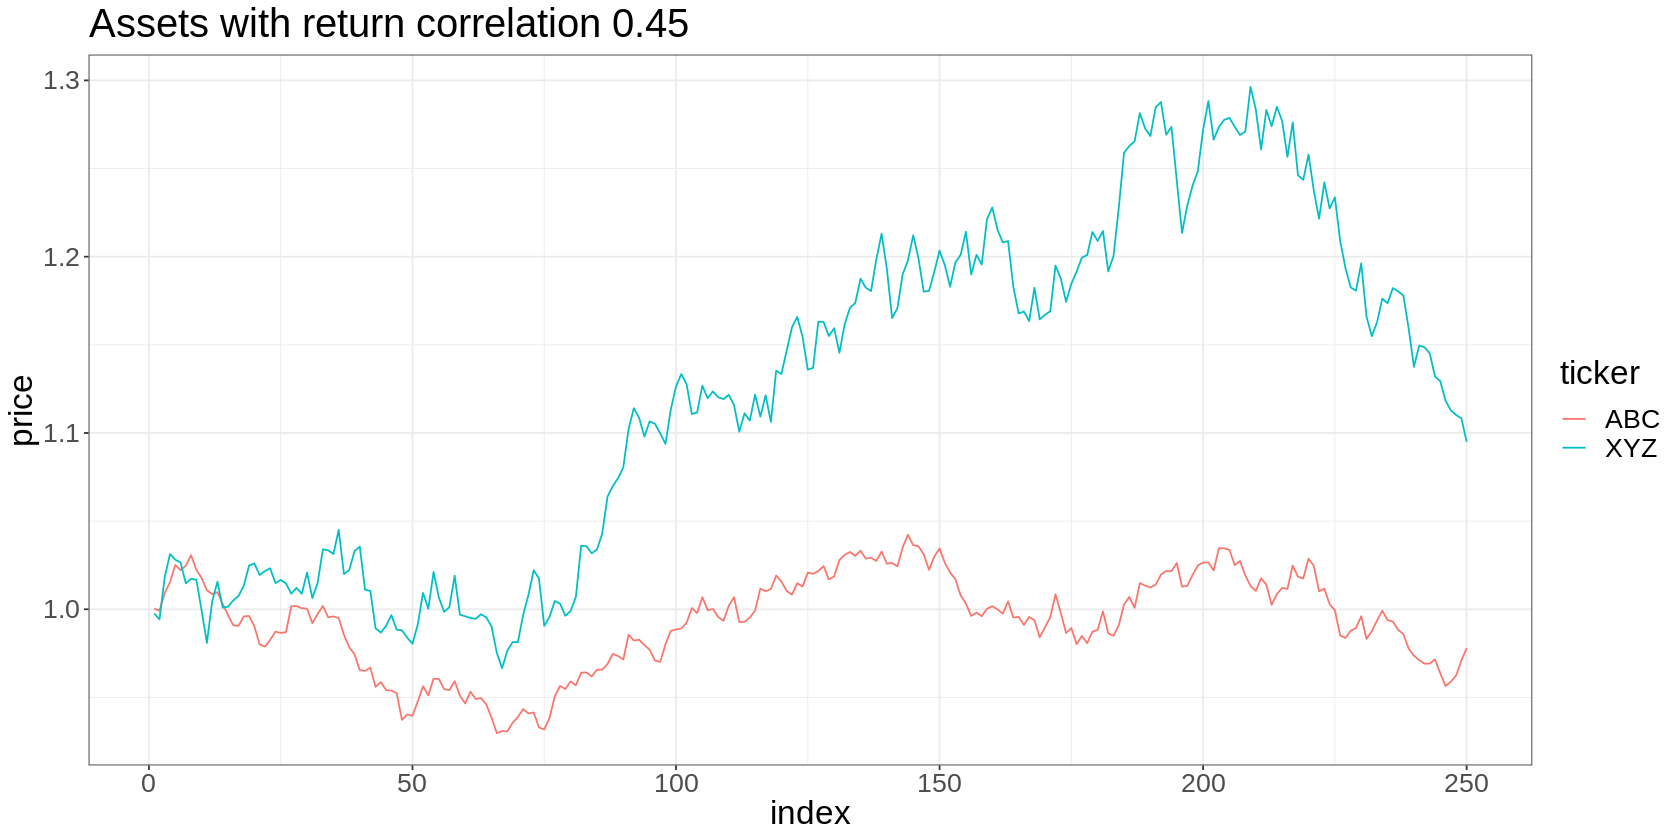

In [ ]:
set.seed(31)

# generate returns series
steps = 250
ABC_ret <- gbm_sim(nsim = 1, t = steps)

# make correlated returns series by adding some noise
XYZ_ret <- ABC_ret + rnorm(steps, 0, 0.01)

# convert to price paths starting at 1
ABC <- cumprod(1+ABC_ret)
XYZ <- cumprod(1+XYZ_ret)

# calculate correlation of returns
port_1_corr <- cor(ABC_ret, XYZ_ret)
port_1_corr

# plot
data.frame(index = 1:steps, ABC = ABC, XYZ = XYZ) %>%
  pivot_longer(-index, names_to = "ticker", values_to = "price") %>%
  ggplot(aes(x = index, y = price, colour = ticker)) +
    geom_line() +
    labs(
      title = glue("Assets with return correlation {round(port_1_corr, 2)}")
    )

Annualised return and volatility for ABC and XYZ:

In [ ]:
mean(ABC_ret)*252
sd(ABC_ret)*sqrt(252)

[1] -0.01773032

[1] 0.09780632

In [ ]:
mean(XYZ_ret)*252
sd(XYZ_ret)*sqrt(252)

[1] 0.1080935

[1] 0.182357

Equal weight portfolio rebalanced at each time step

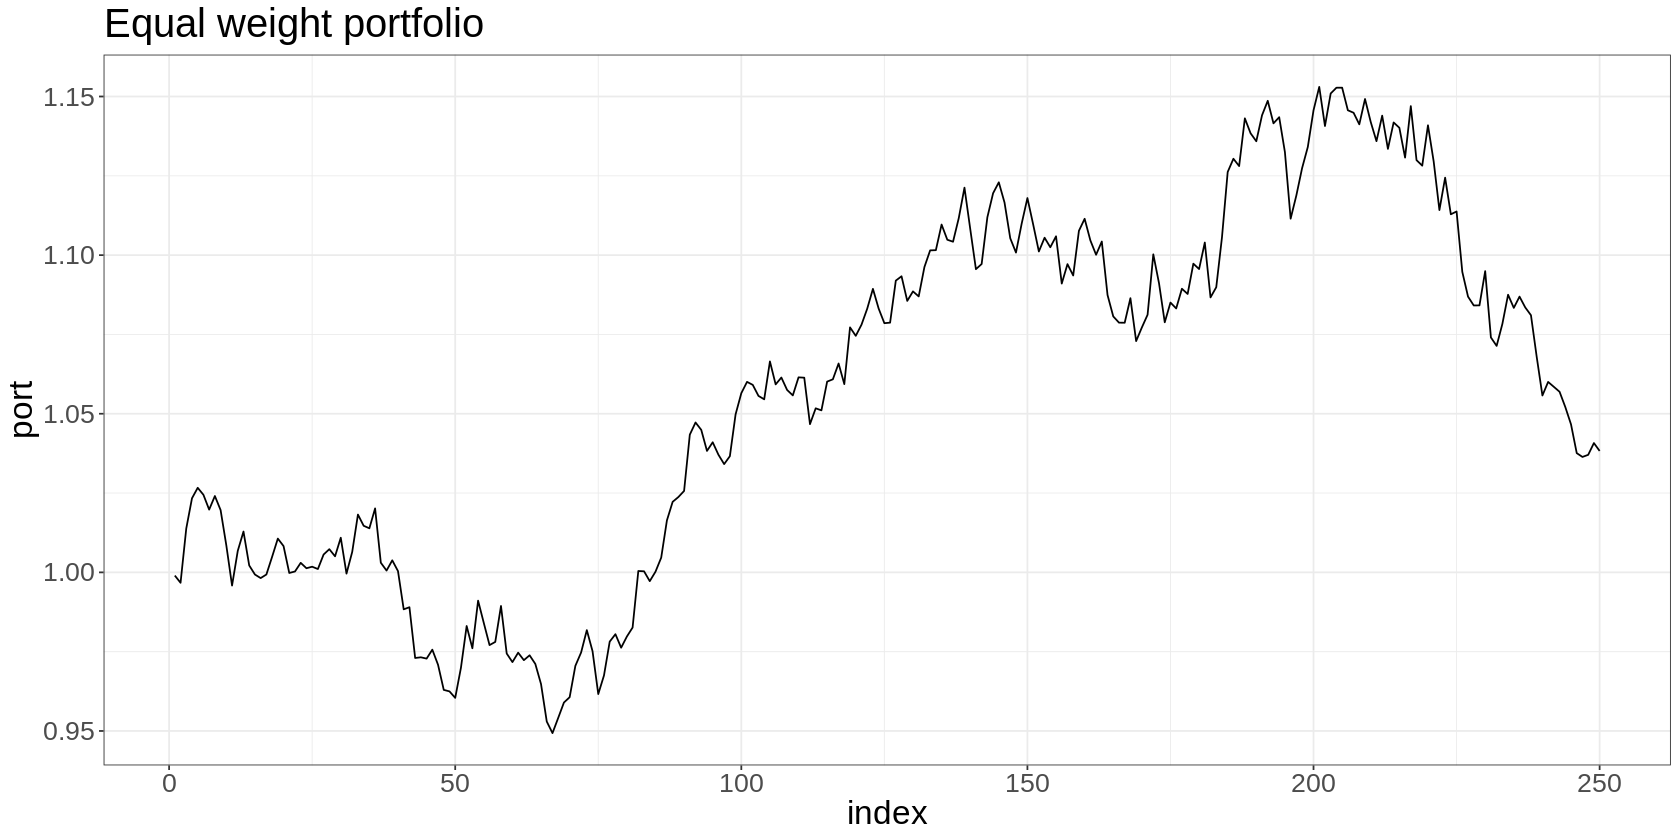

In [ ]:
# equal weight portfolio rebalanced at each time step
port <- 0.5*(ABC_ret + XYZ_ret)

data.frame(index = 1:steps, port = cumprod(1 + port)) %>%
  ggplot(aes(x = index, y = port)) +
    geom_line() +
    labs(title = "Equal weight portfolio")

Annualised portfolio return and volatility:

In [ ]:
mean(port)*252
sd(port)*sqrt(252)

[1] 0.04518161

[1] 0.1212552

Compare with the mean return and mean volatility of our two assets:

In [ ]:
mean(c(-0.0177, 0.0978))
mean(c(0.0978, 0.1824))

[1] 0.04005

[1] 0.1401

We get the mean return, and slightly less than the mean of the volatilities of the two assets. 

Portfolio 2: uncorrelated assets:

[1] -0.09759855

,DEF_ret,TUV_ret,index,port_ret
,<dbl>,<dbl>,<int>,<dbl>
1,0.000331512,-0.0017144853,1,-0.0006914866
2,-0.001184525,-0.0014035373,2,-0.0012940311
3,0.010123382,0.0089464963,3,0.0095349392
4,0.006100692,0.0041482244,4,0.0051244582
5,0.009551798,-0.0079951836,5,0.0007783074
6,-0.002828671,0.0008375986,6,-0.0009955360


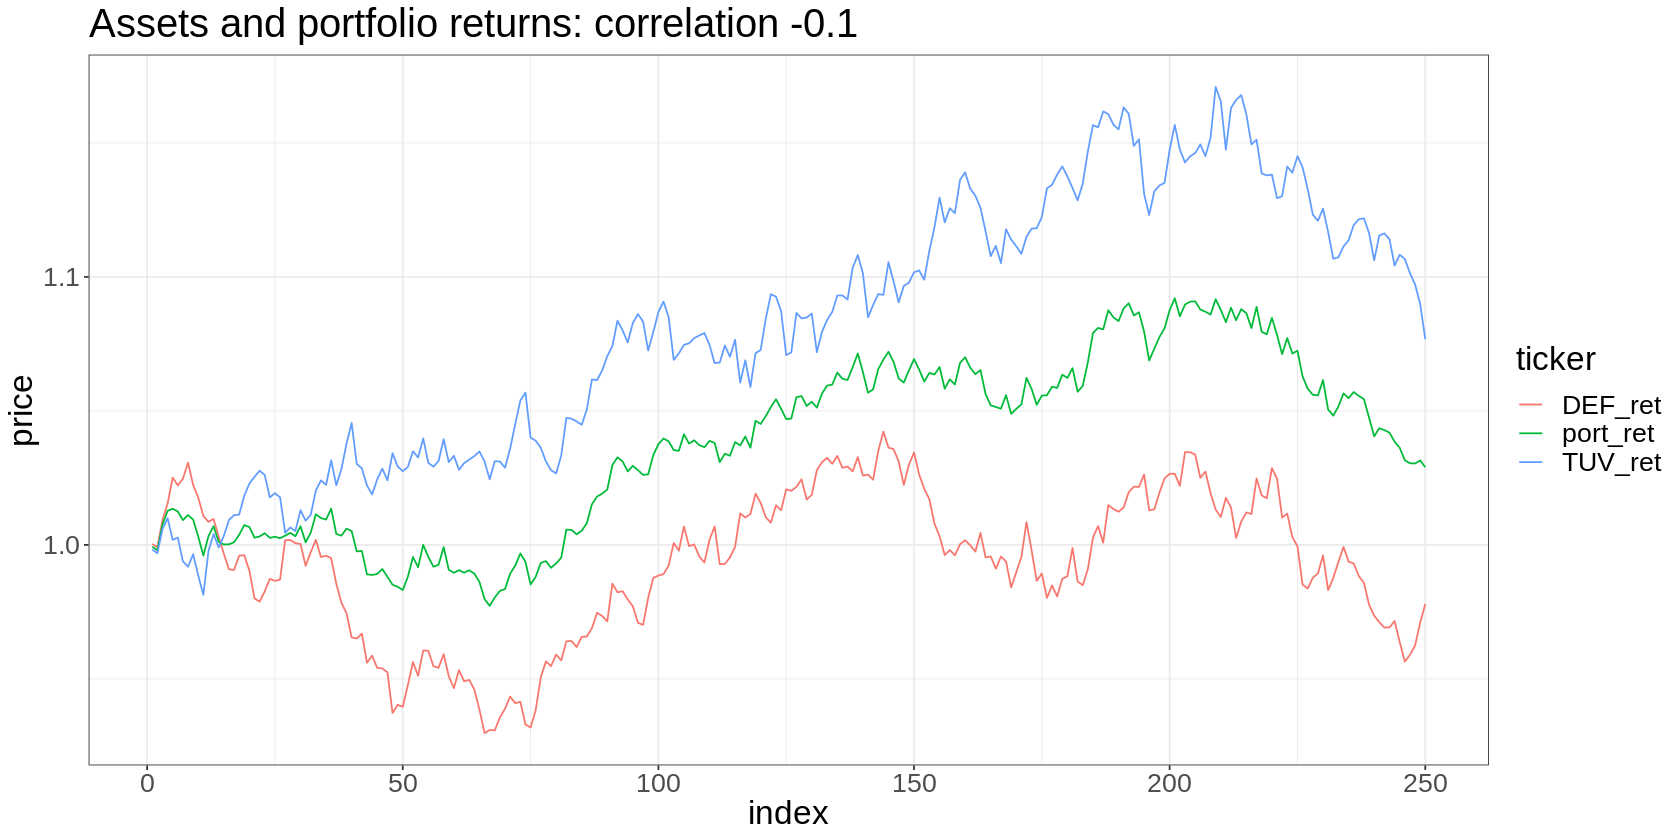

In [ ]:
set.seed(31)
rets <- gbm_sim(nsim = 2, t = steps)
port_2_corr <- cor(rets)[1, 2]
port_2_corr

rets <- data.frame(rets) %>% 
  rename("DEF_ret" = X1, "TUV_ret" = X2) %>%
  mutate(
    index = 1:steps,
    # equal weight portfolio rebalanced at each time step
    port_ret = 0.5*(DEF_ret + TUV_ret)
  )
head(rets)

prices <- rets %>%
  mutate(across(.cols = ends_with("_ret"), .fn = ~cumprod(1 + .x))) %>%
  pivot_longer(-index, names_to = "ticker", values_to = "price")

prices %>%
  ggplot(aes(x = index, y = price, colour = ticker)) +
    geom_line() +
    labs(title = glue("Assets and portfolio returns: correlation {round(port_2_corr, 2)}"))

Return and volatility summary of assets and portfolio:

In [ ]:
rets %>%
  summarise(
    across(
      .cols = -index, 
      .fn = list("AnnRet" = ~252*mean(.x), "AnnVol" = ~sqrt(252)*sd(.x)),
      .names = "{stringr::str_remove(.col, '_ret')}_{.fn}"
    )
  ) 

DEF_AnnRet,DEF_AnnVol,TUV_AnnRet,TUV_AnnVol,port_AnnRet,port_AnnVol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.01773032,0.09780632,0.07989219,0.1035457,0.03108094,0.06765898


Comapring portfolio return and volatility to the mean asset-wise return and volatility:

In [ ]:
mean(c(-0.01777, 0.07989))
mean(c(0.09781, 0.10355))

[1] 0.03106

[1] 0.10068

In the uncorrelated case, at the portfolio level we get the mean return, but significantly less than the average of the two assets' volatilities. 

## Correlation over our full data set

Now we'll move on to some real data...

In [ ]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

# snippet: rw macro quickstart v.0.1
quicksetup(pod = "Macro", path = ".")
head(prices)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AdQt8qghru7wOdtHCKD_Cn2YvlP1L9YWk7KYBe_jzCdiN53-v8PsFA1xzns


Set default bucket name to 'macro_research_pod'



Attempting download of  main_asset_classes_daily_ohlc.csv ...
Transferring main_asset_classes_daily_ohlc.csv ... data is 3.8 Mb please be patient...


ℹ Downloading main_asset_classes_daily_ohlc.csv

✔ Saved main_asset_classes_daily_ohlc.csv to ./main_asset_classes_daily_ohlc.cs…





main_asset_classes_daily_ohlc.csv successfully transferred


Rows: 48566 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (6): open, high, low, close, volume, closeadjusted
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,open,high,low,close,volume,closeadjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMB,1995-01-04,40.22193,40.22193,40.22193,40.22193,0,20.14553
EMB,1995-01-05,40.57014,40.57014,40.57014,40.57014,0,20.31993
EMB,1995-01-06,39.89287,39.89287,39.89287,39.89287,0,19.98072
EMB,1995-01-09,39.32432,39.32432,39.32432,39.32432,0,19.69595
EMB,1995-01-10,37.45455,37.45455,37.45455,37.45455,0,18.75946
EMB,1995-01-11,37.87482,37.87482,37.87482,37.87482,0,18.96996


In [ ]:
# create simple and log returns 
returns <- prices %>%
  select(ticker, date, closeadjusted) %>%
  rename("close" = closeadjusted) %>%
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(
    simple_return = (close - dplyr::lag(close))/dplyr::lag(close),
    fwd_simple_return = dplyr::lead(simple_return),
    log_return = log(close/dplyr::lag(close)),
    fwd_log_return = dplyr::lead(log_return)
  )

tail(returns)

ticker,date,close,simple_return,fwd_simple_return,log_return,fwd_log_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLD,2022-07-25,160.23,-0.002738532,NA,-0.002742289,NA
IEF,2022-07-25,103.85,-0.003550182,NA,-0.003556499,NA
TLT,2022-07-25,117.39,-0.009784901,NA,-0.009833088,NA
VEA,2022-07-25,41.75,0.008210577,NA,0.008177054,NA
VTI,2022-07-25,198.17,0.001364325,NA,0.001363396,NA
VWO,2022-07-25,40.97,0.004659147,NA,0.004648326,NA


Calculate and plot the full-sample correlation matrix:

In [ ]:
cormat <- returns %>%
  ungroup() %>%
  select(date, ticker, simple_return) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = simple_return) %>%
  select(-date) %>%
  na.omit() %>%
  cor()

cormat

,EMB,GLD,IEF,TLT,VEA,VTI,VWO
EMB,1.000000000,0.12369932,-0.01865396,-0.008379779,0.3747669,0.35916372,0.5600727
GLD,0.123699321,1.00000000,0.14719184,0.121135642,0.1100423,0.01652587,0.1328496
IEF,-0.018653958,0.14719184,1.00000000,0.910414083,-0.2754218,-0.29502175,-0.2757846
TLT,-0.008379779,0.12113564,0.91041408,1.000000000,-0.3051217,-0.30659146,-0.2822531
VEA,0.374766943,0.11004235,-0.27542177,-0.305121742,1.0000000,0.67491842,0.7444484
VTI,0.359163717,0.01652587,-0.29502175,-0.306591457,0.6749184,1.00000000,0.7147595
VWO,0.560072681,0.13284955,-0.27578463,-0.282253097,0.7444484,0.71475951,1.0000000


In [ ]:
cormat_plot <- function(cor_mat) {
  cor_mat %>% 
    as.data.frame() %>% 
    rownames_to_column("ticker.x") %>% 
    pivot_longer(-ticker.x, names_to = "ticker.y", values_to = "correlation") %>% 
    mutate(ticker.y = fct_rev(factor(ticker.y))) %>% 
    ggplot(aes(x = ticker.x, y = ticker.y, fill = correlation)) +
      geom_tile() +
      scale_fill_gradient2(low = "#F065DD", mid = "#FFFFFF", high = "#092580", limits = c(-1, 1)) +
      labs(title = "Correlation Matrix", fill = "Correlation") +
      theme(axis.title.x = element_blank(), axis.title.y = element_blank())
}

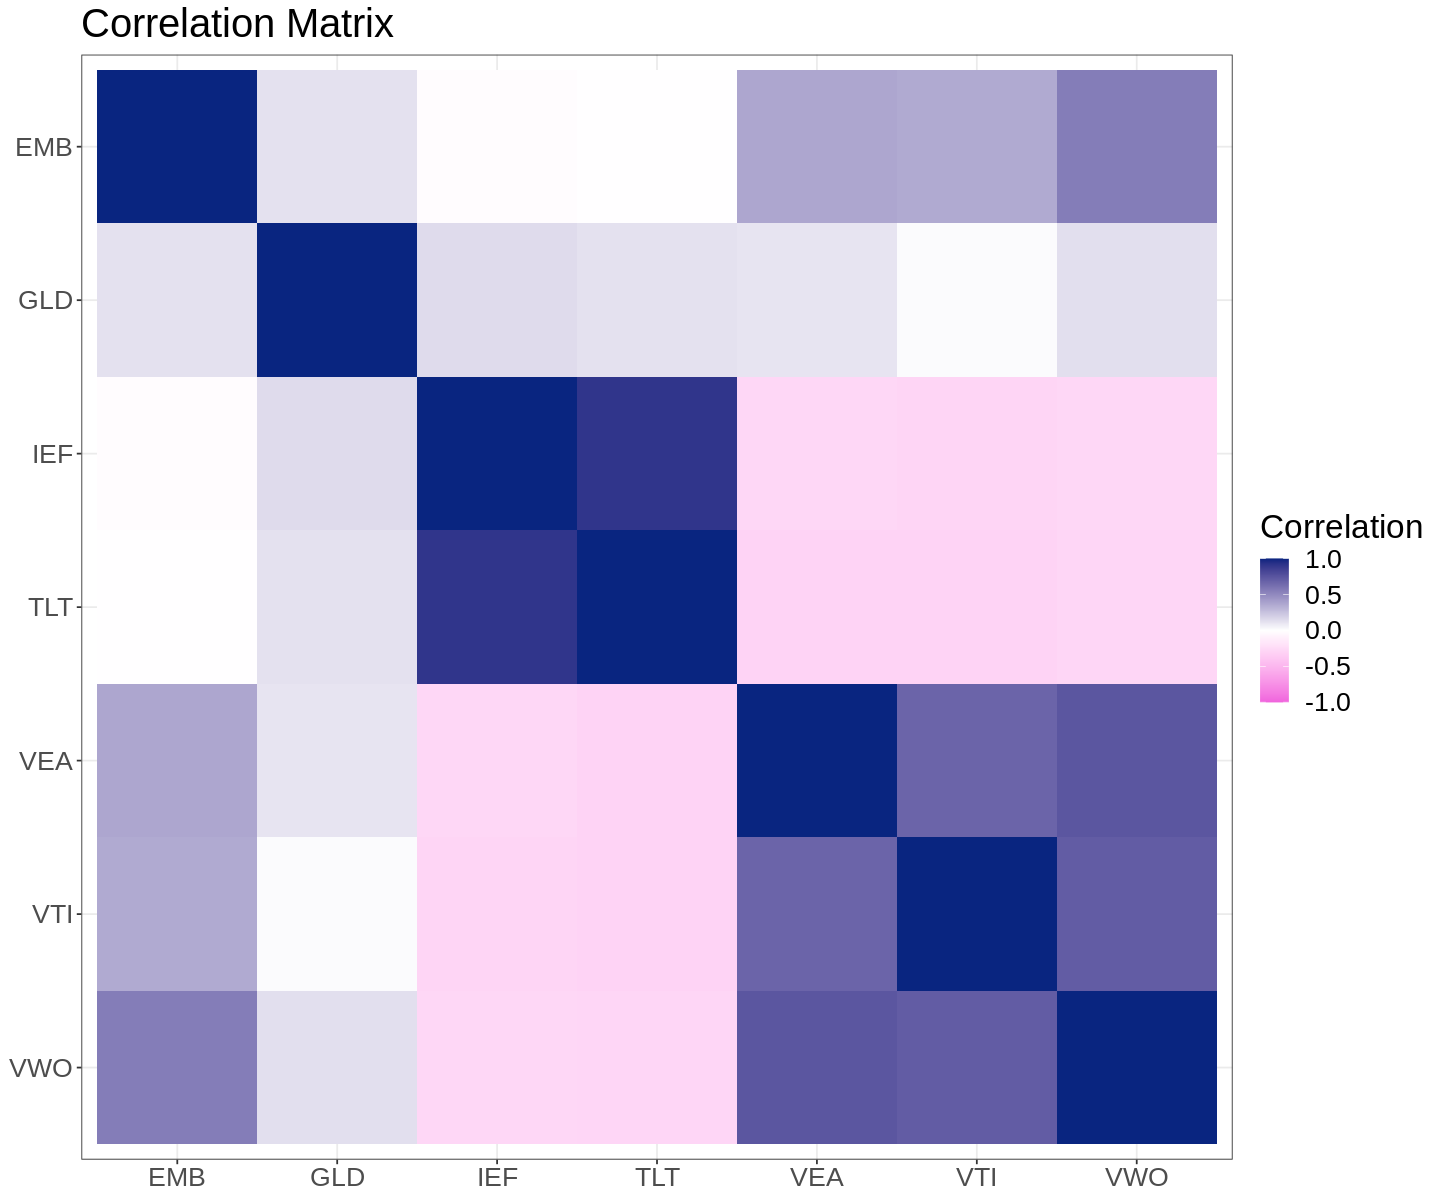

In [ ]:
options(repr.plot.width = 12, repr.plot.height=10)
cormat_plot(cormat)
options(repr.plot.width = 14, repr.plot.height=7)

Over the full sample:
- Stock risk is fairly correlated (VEA, VTI, VWO)
- US treasuries are correlated (IEF, TLT)
- Stocks and treasuries are anti-correlated
- Gold is uncorrelated with everything
- Emerging market bonds have positive correlation with stock risk, and are uncorrelated with treasuries. 

## Rolling correlations

How do pairwise correlations change through time?

In [ ]:
# ditch corr matrix diagonal, one half
wrangle_combos <- function(combinations_df) {
  combinations_df %>%
    ungroup() %>% 
    # drop diagonal 
    dplyr::filter(ticker.x != ticker.y) %>% 
    # get all combinations (tickers) and remove duplicate combos (eg A-AA, AA-A)
    mutate(tickers = ifelse(ticker.x < ticker.y, glue("{ticker.x}, {ticker.y}"), glue("{ticker.y}, {ticker.x}"))) %>%
    distinct(date, tickers, .keep_all = TRUE) 
} 

# calculate rolling pairwise correlations over period
pairwise_corrs <- function(combination_df, period) {
  combination_df %>%
    group_by(tickers) %>%
    arrange(date, .by_group = TRUE) %>%
    mutate(rollingcor = slider::slide2_dbl(
      .x = log_return.x, 
      .y = log_return.y, 
      .f = ~cor(.x, .y), 
      .before = period, 
      .complete = TRUE)
    ) %>%
    select(date, tickers, rollingcor)
} 

# calculate mean pairwise correlations by date
mean_pw_cors <- function(correlations_df) {
  correlations_df %>%
    group_by(date) %>%
    summarise(mean_pw_corr = mean(rollingcor, na.rm = TRUE))
} 

roll_pairwise_corrs <- returns %>%
  full_join(returns, by = "date") %>% 
  wrangle_combos() %>% 
  pairwise_corrs(250) 
  
tail(roll_pairwise_corrs)

date,tickers,rollingcor
<date>,<chr>,<dbl>
2022-07-18,"VTI, VWO",0.6722453
2022-07-19,"VTI, VWO",0.6759091
2022-07-20,"VTI, VWO",0.6739360
2022-07-21,"VTI, VWO",0.6748742
2022-07-22,"VTI, VWO",0.6817959
2022-07-25,"VTI, VWO",0.6856724


In [ ]:
roll_pairwise_corrs_plot <- function(roll_corr_df, facet = FALSE) {
  lab <- c(x = "Date", y = "Correlation", title = "Rolling 12-month Correlation")
  
  if(facet) {
    roll_corr_df %>% 
      group_by(tickers) %>% 
      ggplot(aes(x = date, y = rollingcor)) + 
      geom_line() + 
      facet_wrap(~tickers, ncol = 1) +
      labs(
        x = lab["x"],
        y = lab["y"],
        title = lab["title"]
      )
  } else {
    roll_corr_df %>% 
      group_by(tickers) %>% 
      ggplot(aes(x = date, y = rollingcor, colour = tickers)) + 
      geom_line()  +
      labs(
        x = lab["x"],
        y = lab["y"],
        title = lab["title"]
      )
  }
}

Warning message:
“Removed 5271 row(s) containing missing values (geom_path).”


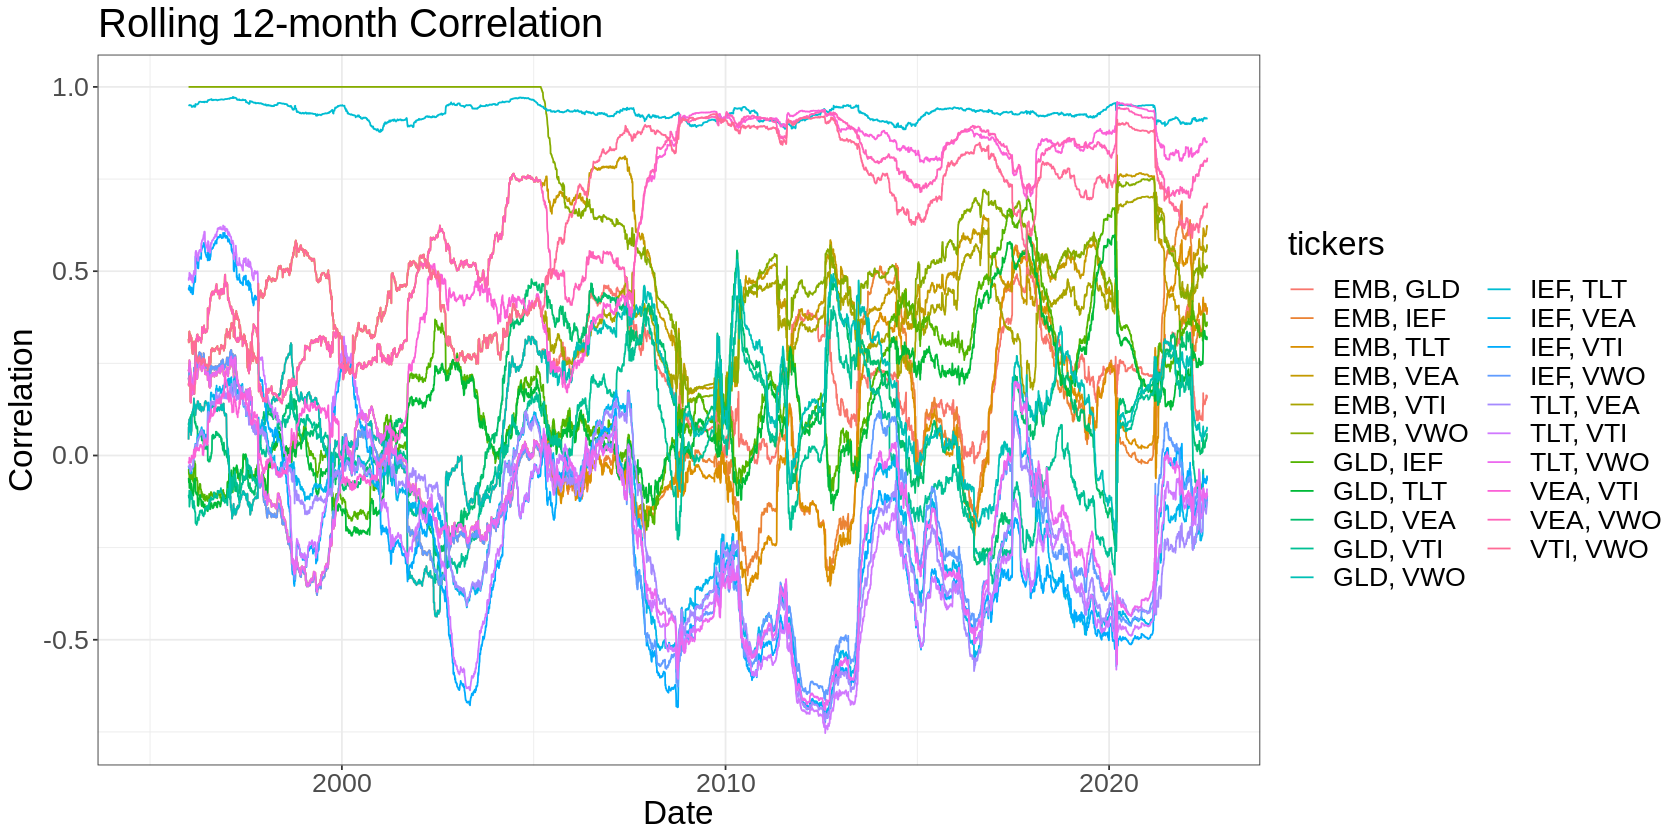

In [ ]:
roll_pairwise_corrs_plot(roll_pairwise_corrs)

Main takeaways:

- Correlation magnitudes change all the time  
- Some pairs of assets are more persistently positively or negatively correlated than others. 
- Previously noted how correlation dynamics changed post-GFC 
- To the extent that we can predict correlations, we can get a diversification benefit.

But can we predict correlations?

`geom_smooth()` using formula 'y ~ x'



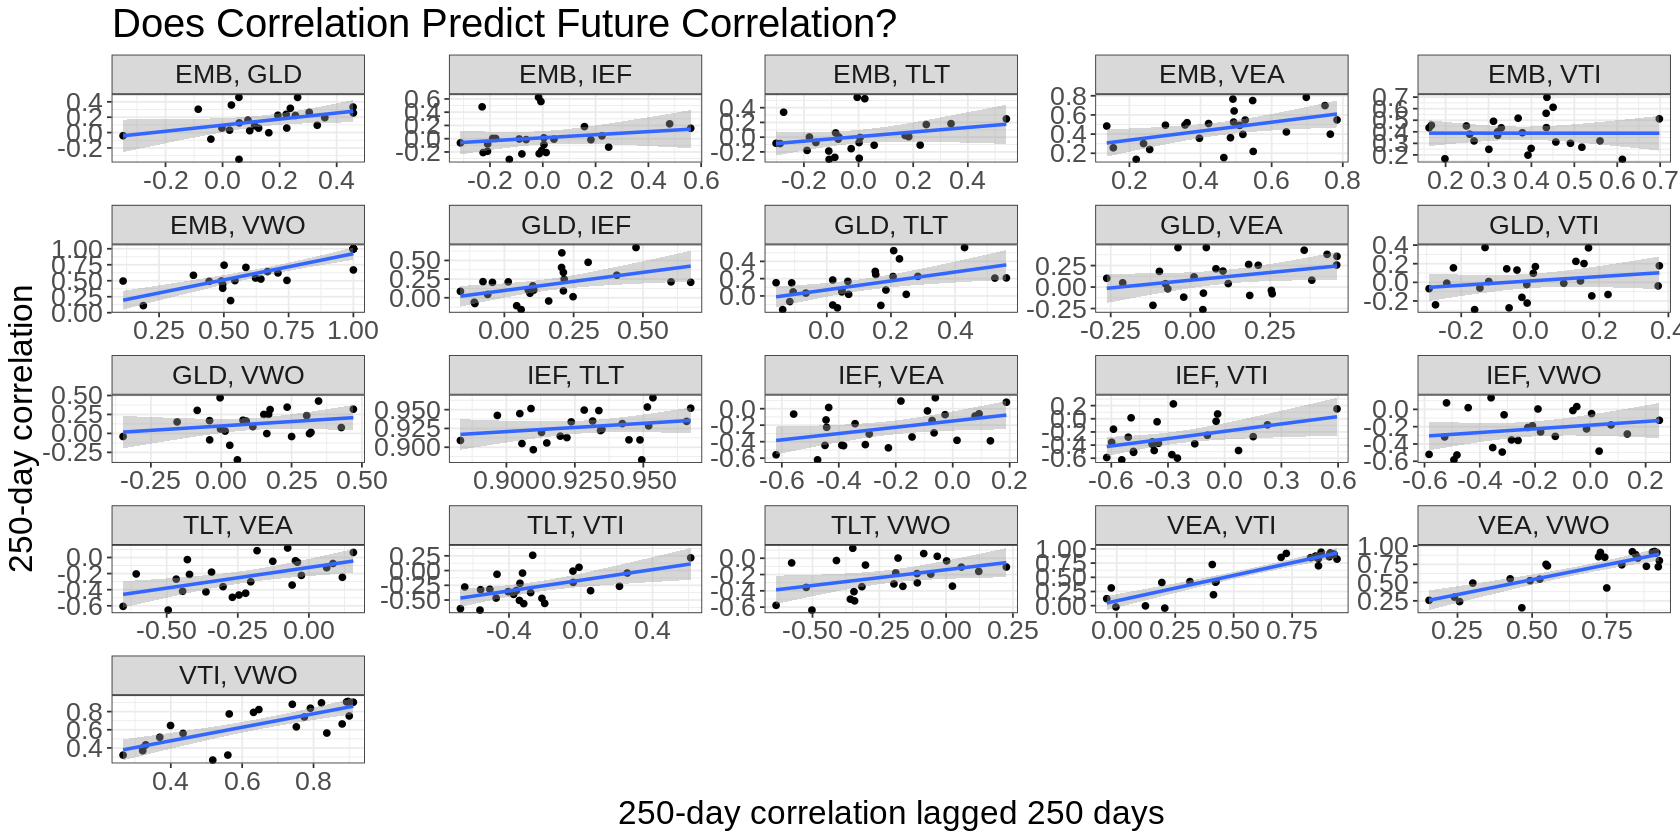

In [ ]:
wdw <- 250
roll_pairwise_corrs %>% 
  # filter(tickers == "VTI, VWO") %>%
  group_by(tickers) %>%
  mutate(corr_lag = dplyr::lag(rollingcor, wdw)) %>%
  na.omit() %>%
  dplyr::filter(row_number() %% wdw == 0) %>%
  ggplot(aes(x = corr_lag, y = rollingcor)) +
    geom_point() +
    geom_smooth(method = lm) +
    facet_wrap(~tickers, scales = 'free') +
    labs(
      x = glue::glue("{wdw}-day correlation lagged {wdw} days"),
      y = glue::glue("{wdw}-day correlation"),
      title = "Does Correlation Predict Future Correlation?"
    )

## Compare inverse vol with ERC

Next we'll compare inverse vol weighting with ERC. We'll build portfolios that weight assets according to both approaches, and compare their impact on portfolio diversification and volatility. 

### Inverse vol

Size based on 90-day volatility estimate.

In [ ]:
period = 90

returns <- returns %>%
  group_by(ticker) %>%
  mutate(
    vol = slider::slide_dbl(
      .x = log_return, 
      .f = ~ sqrt(252)*sd(.x), 
      .before = period, 
      .complete = TRUE
    ),
    eq_vol_weight_raw = 1/vol,
    eq_var_weight_raw = 1/(vol^2)
  ) %>%
  # weights <- raw_weights / rowSums(raw_weights) # Normalise weights to add to 1
  group_by(date) %>%
  mutate(
    eq_vol_weight = eq_vol_weight_raw / sum(eq_vol_weight_raw),
    eq_var_weight = eq_var_weight_raw / sum(eq_var_weight_raw)
  ) %>%
  ungroup() %>%
  na.omit()

tail(returns)

port_returns <- returns %>%
  group_by(date) %>%
  summarise(
    port_return = sum(eq_vol_weight*fwd_simple_return)
  ) 

ticker,date,close,simple_return,fwd_simple_return,log_return,fwd_log_return,vol,eq_vol_weight_raw,eq_var_weight_raw,eq_vol_weight,eq_var_weight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLD,2022-07-22,160.67,0.002495788,-0.002738532,0.002492679,-0.002742289,0.1411108,7.086631,50.22034,0.17544442,0.19342807
IEF,2022-07-22,104.22,0.011451863,-0.003550182,0.011386787,-0.003556499,0.1047022,9.550896,91.21961,0.23645245,0.35134036
TLT,2022-07-22,118.55,0.016811047,-0.009784901,0.016671306,-0.009833088,0.2033193,4.918373,24.19039,0.12176463,0.09317142
VEA,2022-07-22,41.41,-0.003369434,0.008210577,-0.003375124,0.008177054,0.2217684,4.509210,20.33297,0.11163494,0.07831422
VTI,2022-07-22,197.90,-0.010846204,0.001364325,-0.010905453,0.001363396,0.2708150,3.692558,13.63498,0.09141701,0.05251634
VWO,2022-07-22,40.78,-0.010194175,0.004659147,-0.010246491,0.004648326,0.2501710,3.997265,15.97813,0.09896069,0.06154117


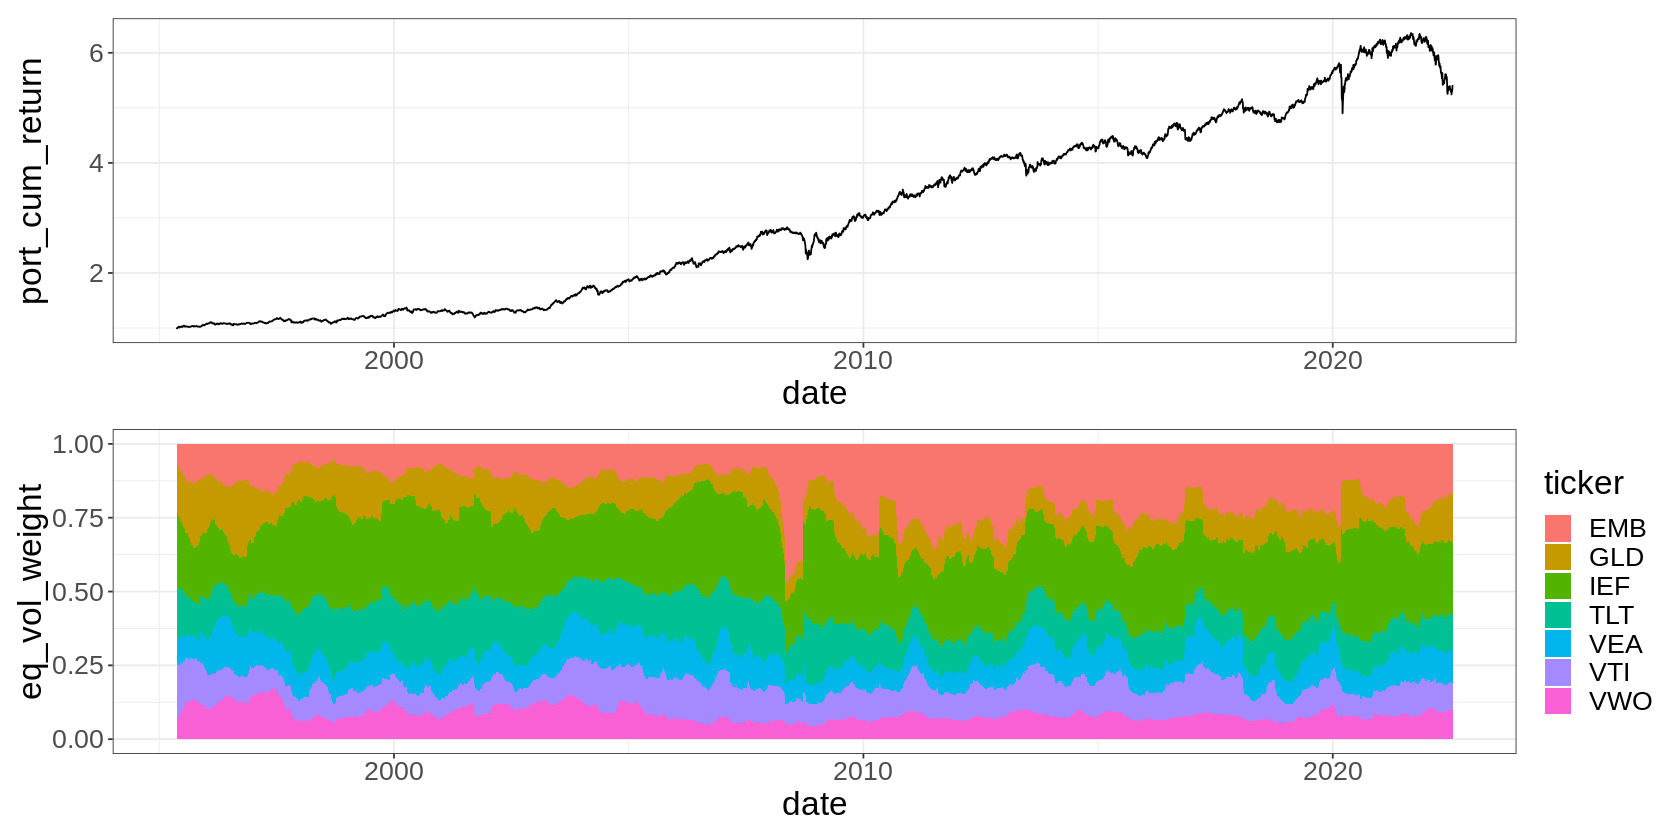

In [ ]:
portfolio_returns_plot <- port_returns %>%
  na.omit() %>%
  mutate(port_cum_return = cumprod(1+port_return)) %>%
  ggplot(aes(x = date, y = port_cum_return)) +
    geom_line()

weights_plot <- returns %>%
  ggplot(aes(x = date, y = eq_vol_weight, fill = ticker)) +
    geom_area()

portfolio_returns_plot / weights_plot

In [ ]:
port_returns %>%
  summarise(
    Ann.Return = 252*mean(port_return),
    Ann.Vol = sqrt(252)*sd(port_return),
    Ann.Sharpe = Ann.Return/Ann.Vol
  )

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.06431198,0.06725215,0.9562813


### Marginal risk contribution

MRC is the amount of volatility an asset adds to a portfolio. 

It's calculated by:
- Caculate volatility of entire portfolio, $V$
- Remove asset 1
- Calculate volatility of portfolio without asset 1, $V'$
- MRC for asset 1 = $V - V'$
- Repeat for all assets

An asset's MRC depends on:
- what's in the portfolio already 
- the thing that you're adding 

First, we'll calculate a "summary" MRC for each asset over the entire sample:

In [ ]:
# marginal risk contribution

# given a dataframe of returns and weights, calculate marginal risk contribution by asset
marginal_rc <- function(returns) {
  # portfolio vol
  port_vol <- returns %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(eq_vol_weight*fwd_simple_return)
    ) %>%
    ungroup() %>%
    summarise(Ann.Vol = sqrt(252)*sd(port_return)) %>%
    pull(Ann.Vol)

  # mrc
  assets <- pull(distinct(returns, ticker))
  mrcs <- list()

  for(asset in assets) {
    sub_port_vol <- returns %>%
      filter(ticker != asset) %>%
      group_by(date) %>%
      na.omit() %>%
      summarise(
        port_return = sum(eq_vol_weight*fwd_simple_return)
      ) %>%
      ungroup() %>%
      summarise(Ann.Vol = sqrt(252)*sd(port_return)) %>%
      pull(Ann.Vol)

    mrc <- (port_vol - sub_port_vol)/port_vol
    names(mrc) <- asset
    mrcs <- append(mrcs, mrc)
  }
  mrcs
}

mrcs <- marginal_rc(returns)
mrcs

In [ ]:
as.data.frame(mrcs) %>%
  pivot_longer(cols = everything(), names_to = "ticker", values_to = "mrc") %>%
  ggplot(aes(x = ticker, y = mrc)) +
    geom_bar(stat = "identity") +
    labs(title = "Marginal risk contribution by asset")

We can also estimate MRC over time in a rolling fashion. We'll use a 90-day window to estimate volatilities:

In [ ]:
# over time, using a 90-day vol estimate
vol_wdw <- 90

# calculate rolling portfolio vols for each portfolio subset
# then subtract from portfolio vol of full port
port_vol <- returns %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(eq_vol_weight*fwd_simple_return)
    ) %>%
    mutate(
      port = slider::slide_dbl(
        .x = port_return, 
        .f = ~ sqrt(252)*sd(.x), 
        .before = vol_wdw, 
        .complete = TRUE
      )
    ) %>%
    select(date, port) 

# mrc
assets <- pull(distinct(returns, ticker))
mrcs <- list()

for(asset in assets) {
  sub_port_vol <- returns %>%
    filter(ticker != asset) %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(eq_vol_weight*fwd_simple_return)
    ) %>%
    mutate(
      "{asset}" := slider::slide_dbl(
        .x = port_return, 
        .f = ~ sqrt(252)*sd(.x), 
        .before = vol_wdw, 
        .complete = TRUE
      )
    ) %>%
    select(date, {{asset}})
  mrcs <- append(mrcs, list(sub_port_vol))
}

In [ ]:
mrcs <- mrcs %>%
  purrr::reduce(left_join, by = "date") %>%
  left_join(port_vol, by = "date") %>%
  mutate(across(.cols = c(-date, -port), .fns = ~ (port - .x)/port)) %>%
  select(-port)

tail(mrcs)

In [ ]:
mrcs %>%
  pivot_longer(-date, names_to = "ticker", values_to = "marginal_risk_contribution") %>%
    ggplot(aes(x = date, y = marginal_risk_contribution, fill = ticker)) +
      geom_area() +
      labs(
        title = "Asset-wise marginal risk contribution", 
        subtitle = "Inverse vol weighted portfolio",
        y = "MRC, %"
      )

The MRCs don't necessarily add up to the portfolio volatility - the MRC is simply "the amount of volatility an asset adds to the other stuff". 

We can think of the shortfall between the sum of the MRCs and the portfolio volatility as "unrewarded volatility" - said differently, the volatility that is "theoretically diversifiable" if we can do a better job of accounting for co-movement of assets. 

Here's a plot of our "theoretically diviersifiable risk":

In [ ]:
mrcs %>%
  mutate(unrewarded_vol = 1 - (EMB + GLD + IEF + TLT + VEA + VTI + VWO)) %>%
  ggplot(aes(x = date, y = unrewarded_vol)) +
    geom_line() +
    labs(
      title = "Theoretically diversifiable risk"
    )

"Theoretically" is a key point - in reality, we can't make perfect predictions about co-movement. But we can certainly say *something* about them, as we saw in the past vs future correlation scatterplots above. Let's find out if we can say *enough* about them to make it worth our while to try to do a better job of dealing with that "diversifiable risk."

## The ERC portfolio

We'll try to account for co-movement of assets by building the ERC portfolio. 

### The FRAPO package

FRAPO ("Financial Risk Modelling and Portfolio Optimisation with R") contains a bunch of algorithms for doing portfolio construction. It accompanies a book of the same title. 

We're going to use it to calculate weights for our ERC approach. 

In [ ]:
install.packages("FRAPO")
library(FRAPO)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘slam’, ‘timeDate’, ‘cccp’, ‘Rglpk’, ‘timeSeries’




FRAPO calculates weights for the ERC portfolio using the portoflio covariance matrix. 

First, create a 252-day covariance matrix for each day:

In [ ]:
prd <- 252

wide_rets <- returns %>%
    select(ticker, date, log_return) %>%
    pivot_wider(date, names_from = ticker, values_from = log_return) %>%
    na.omit()

covmats <- vector(mode = "list", length = nrow(wide_rets))

for(i in prd:nrow(wide_rets)) {
  covmat <- wide_rets[(i-prd):i, ] %>%
        select(-date) %>%
        as.matrix() %>%
        cov()

  covmats[[i]] <- covmat
}

In [ ]:
covmats[[prd-1]]
covmats[[prd]]

Calculate ERC weights:

In [ ]:
erc_wgts <- vector(mode = "list", length = nrow(wide_rets))

num_assets <- ncol(wide_rets) - 1
tickers <- colnames(wide_rets %>% select(-date))

for(i in 1:nrow(wide_rets)) {
  if(is.null(covmats[[i]])) {
    erc_wgts[[i]] <- rep(NA, num_assets)
    next  
  } 

  # marginal risk contribution based on covariance matrix 
  capture.output(these_wgts <- FRAPO::PERC(Sigma = covmats[[i]]), file = "NULL")  # too much output...
  erc_wgts[[i]] <- Weights(these_wgts) 
}

In [ ]:
erc_wgts[[252]]

Some wrangling to make nice dataframes:

In [ ]:
erc_wgts <- as.data.frame(do.call(rbind, erc_wgts))
names(erc_wgts) <- tickers

# add date column and pivot long
erc_wgts <- erc_wgts %>%
  bind_cols(
    returns %>% 
      select(ticker, date, simple_return) %>%
      pivot_wider(date, names_from = ticker, values_from = simple_return) %>%
      select(date)
  ) %>%
  pivot_longer(-date, names_to = "ticker", values_to = "erc_wgt") %>%
  # join returns
  left_join(
    returns %>% select(ticker, date, simple_return, fwd_simple_return),
    by = c("ticker", "date")
  )

head(erc_wgts)

Plot portfolio equity and asset weights (note assumes costless daily rebalancing):

In [ ]:
erc_port_returns <- erc_wgts %>%
  na.omit() %>%
  group_by(date) %>%
  summarise(
    port_return = sum(fwd_simple_return*erc_wgt/100.)
  ) 

erc_portfolio_returns_plot <- erc_port_returns %>%
  mutate(port_cum_return = cumprod(1+port_return)) %>%
  ggplot(aes(x = date, y = port_cum_return)) +
    geom_line()

erc_weights_plot <- erc_wgts %>%
  ggplot(aes(x = date, y = erc_wgt, fill = ticker)) +
    geom_area()

erc_portfolio_returns_plot / erc_weights_plot

In [ ]:
erc_port_returns %>%
  summarise(
    Ann.Return = 252*mean(port_return),
    Ann.Vol = sqrt(252)*sd(port_return),
    Ann.Sharpe = Ann.Return/Ann.Vol
  )

Calculate marginal risk contributions:

In [ ]:
# marginal risk contribution

# portfolio vol
port_vol <- erc_wgts %>%
  na.omit() %>%
  group_by(date) %>%
  summarise(
    port_return = sum(fwd_simple_return*erc_wgt/100.)
  ) %>%
  ungroup() %>%
  summarise(Ann.Vol = sqrt(252)*sd(port_return)) %>%
  pull(Ann.Vol)

# mrc
assets <- pull(distinct(erc_wgts, ticker))
mrcs <- list()

for(asset in assets) {
  sub_port_vol <- erc_wgts %>%
    dplyr::filter(ticker != asset) %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(fwd_simple_return*erc_wgt/100.)
    ) %>%
    ungroup() %>%
    summarise(Ann.Vol = sqrt(252)*sd(port_return)) %>%
    pull(Ann.Vol)

  mrc <- (port_vol - sub_port_vol)/port_vol
  names(mrc) <- asset
  mrcs <- append(mrcs, mrc)
}

In [ ]:
as.data.frame(mrcs) %>%
  pivot_longer(cols = everything(), names_to = "ticker", values_to = "mrc") %>%
  ggplot(aes(x = ticker, y = mrc)) +
    geom_bar(stat = "identity") +
    labs(title = "Marginal risk contribution by asset")

We can also estimate MRC over time in a rolling fashion. We'll use a 90-day window to estimate volatilities:

In [ ]:
# over time, using a 90-day vol estimate
vol_wdw <- 90

# calculate rolling portfolio vols for each portfolio subset
# then subtract from portfolio vol of full port
port_vol <- erc_wgts %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(fwd_simple_return*erc_wgt/100.)
    ) %>%
    dplyr::mutate(
      port = slider::slide_dbl(
        .x = port_return, 
        .f = ~ sqrt(252)*sd(.x), 
        .before = vol_wdw, 
        .complete = TRUE
      )
    ) %>%
    select(date, port) 

# get vols of portfolio subsets
assets <- pull(distinct(erc_wgts, ticker))
mrcs <- list()

for(asset in assets) {
  sub_port_vol <- erc_wgts %>%
    dplyr::filter(ticker != asset) %>%
    group_by(date) %>%
    na.omit() %>%
    summarise(
      port_return = sum(fwd_simple_return*erc_wgt/100.)
    ) %>%
    dplyr::mutate(
      "{asset}" := slider::slide_dbl(
        .x = port_return, 
        .f = ~ sqrt(252)*sd(.x), 
        .before = vol_wdw, 
        .complete = TRUE
      )
    ) %>%
    select(date, {{asset}})
  mrcs <- append(mrcs, list(sub_port_vol))
}

In [ ]:
# make a dataframe of mrcs from our list of subset-portfolio vols
mrcs <- mrcs %>%
  purrr::reduce(left_join, by = "date") %>%
  left_join(port_vol, by = "date") %>%
  mutate(across(.cols = c(-date, -port), .fns = ~ (port - .x)/port)) %>%
  select(-port)

tail(mrcs)

In [ ]:
mrcs %>%
  pivot_longer(-date, names_to = "ticker", values_to = "marginal_risk_contribution") %>%
    ggplot(aes(x = date, y = marginal_risk_contribution, fill = ticker)) +
      geom_area() +
      labs(
        title = "Asset-wise marginal risk contribution", 
        subtitle = "Equal risk contribution portfolio",
        y = "MRC, %"
      )

Here's a plot of our "theoretically diviersifiable risk":

In [ ]:
mrcs %>%
  mutate(unrewarded_vol = 1 - (EMB + GLD + IEF + TLT + VEA + VTI + VWO)) %>%
  ggplot(aes(x = date, y = unrewarded_vol)) +
    geom_line() +
    labs(
      title = "Theoretically diversifiable risk"
    )

On average, the ERC approach does a good job of managing co-movements in asset classes. It tends to bump up the allocations to bonds and gold, which has a diversifying effect. 

We only see a very minor improvement in sharpe ratio in the backtest... but of course that's not our goal here. 